# Load The Model

In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Paths where you saved the model + tokenizer
model_path = "./mt5-small_model"
tokenizer_path = "./mt5-small_tokenizer"

# Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    id2label={0: "Human", 1: "AI"},
    label2id={"Human": 0, "AI": 1}
)

# Create pipeline for inference
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# --- Test a random text ---
test_text = "এই লেখাটি কৃত্রিম বুদ্ধিমত্তা দ্বারা লেখা হয়েছে।"
result = classifier(test_text)

print("Input:", test_text)
print("Prediction:", result)


c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.sparse import csr_matrix, issparse
Device set to use cuda:0


Input: এই লেখাটি কৃত্রিম বুদ্ধিমত্তা দ্বারা লেখা হয়েছে।
Prediction: [{'label': 'Human', 'score': 0.9870054721832275}]


# Load Unseen Data

Dataset head:
                                                text  label category
0  ‘তোমার ছেলে সঙ্গে যাচ্ছে না। সে পুলিশের হাত থে...  human   novels
1  ট্রেনে বার্থ পাওয়া গেল। স্টেশনমাস্টারই ব্যবস্...  human   novels
2  বৃদ্ধ বিরক্ত। কাগজওয়ালা বনবিহারীকে বলল, ‘এই ম...  human   novels
3  আঙুল দিয়ে ওপরটা দেখিয়ে দিল।’ কালীচরণ বলল, ‘আ...  human   novels
4  তারপরেই বৃদ্ধের গলা কানে এল, ‘বনবিহারীবাবু, দর...  human   novels

Unique labels in dataset: ['human' 'ai']


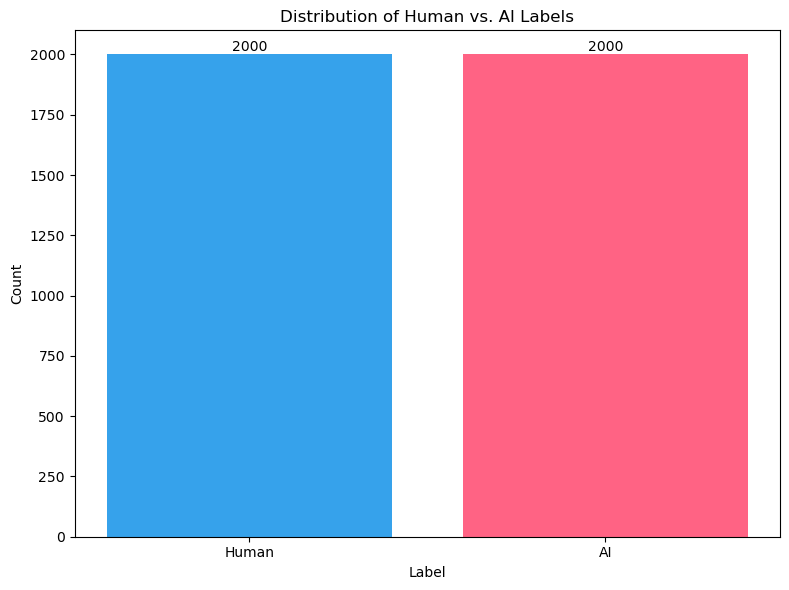

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("../../Unseen Data/Unseen_dataset.csv")

# Check the first few rows and the unique labels
print("Dataset head:")
print(data.head())
print("\nUnique labels in dataset:", data['label'].unique())

# Map labels to human-readable format
label_map = {"human": "Human", "ai": "AI"}
data["label"] = data["label"].map(label_map)

# Count labels
label_counts = data['label'].value_counts()
# Plot bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['#36A2EB', '#FF6384'])

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # x position (center of bar)
        height,  # y position (top of bar)
        f'{int(height)}',  # Count value
        ha='center',  # Horizontal alignment
        va='bottom'  # Vertical alignment (just above the bar)
    )

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Human vs. AI Labels')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Device set to use cuda:0
Classifying texts: 100%|██████████| 4000/4000 [03:05<00:00, 21.52it/s]



Classification Report:
              precision    recall  f1-score   support

       Human       0.52      0.98      0.68      2000
          AI       0.83      0.10      0.18      2000

    accuracy                           0.54      4000
   macro avg       0.68      0.54      0.43      4000
weighted avg       0.68      0.54      0.43      4000


Confusion Matrix:
[[1961   39]
 [1803  197]]


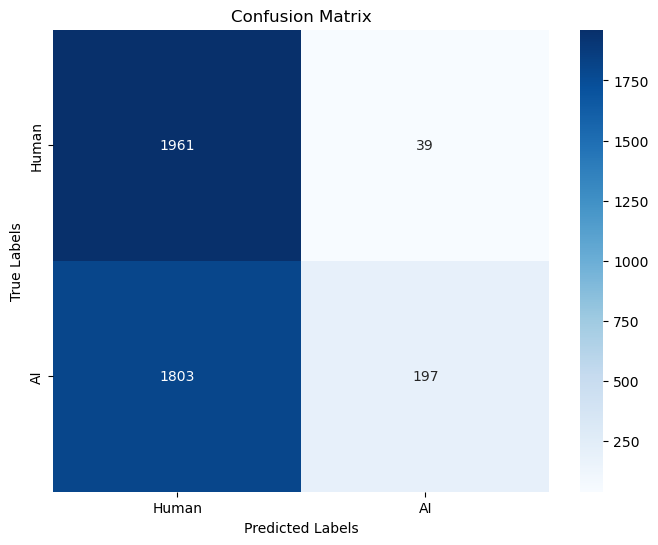

In [3]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar
# Make predictions on the dataset with a progress bar

# Create pipeline for inference with truncation enabled
classifier = pipeline(
    "text-classification", 
    model=model, 
    tokenizer=tokenizer,
    truncation=True,  # This will automatically truncate long texts
    max_length=512   # Explicitly set max length to model's capacity
)

predictions = []
for text in tqdm(data['text'], desc="Classifying texts"):
    # The pipeline will now automatically truncate long texts
    result = classifier(text)
    predictions.append(result[0]['label'])

# Convert predictions to numerical values (0 for Human, 1 for AI)
predicted_labels = [0 if pred == "Human" else 1 for pred in predictions]

# Get the true labels and convert them to numerical values
# First, check what the labels look like in the dataset
unique_labels = data['label'].unique()

# Create a mapping based on the actual labels in the dataset
if 'human' in unique_labels and 'ai' in unique_labels:
    label_mapping = {'human': 0, 'ai': 1}
elif 'Human' in unique_labels and 'AI' in unique_labels:
    label_mapping = {'Human': 0, 'AI': 1}
else:
    # If the labels are in a different format, try to infer
    print("Warning: Unrecognized label format. Attempting to infer mapping.")
    if len(unique_labels) == 2:
        # Assume the first unique label is "human" and the second is "ai"
        label_mapping = {unique_labels[0]: 0, unique_labels[1]: 1}
        print(f"Inferred label mapping: {label_mapping}")
    else:
        raise ValueError("Could not determine label mapping. Please check the label column.")

true_labels = data['label'].map(label_mapping).values

# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=["Human", "AI"])
print("\nClassification Report:")
print(class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('Unseen confusion_matrix.png')
plt.show()